In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# train, test set을 pandas로 불러오자
train = pd.read_csv('/kaggle/input/titanic/train.csv', index_col = 0)
test = pd.read_csv('/kaggle/input/titanic/test.csv', index_col = 0)
gs = pd.read_csv('/kaggle/input/titanic/gender_submission.csv', index_col = 0)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


1. 생사 여부(생 / 사)
2. 티켓 클래스(First, Second, Third)
3. 성별(남 / 여)
4. 나이
5. 형제, 배우자등 
6. 부모, 자식 
7. 티켓 번호
8. 운임 값
9. 선실 번호
10. 승차한 항만 C = 셰르부르옥트빌 / Q = 퀸스타운 / S = 사우스햄튼

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


train과 test의 정보를 살펴봄으로써 Target Label이 'Survived'인 것을 확인 할 수 있었다.

In [5]:
# 1. Data Quality checks
# 1. 결측값 확인
train.isnull().any().any()

True

결측값 있는지 확인 해주는 과정

True일 경우 결측값이 존재한다는 것이므로 missingno library 사용해서 시각화해서 관찰해보자

<AxesSubplot:>

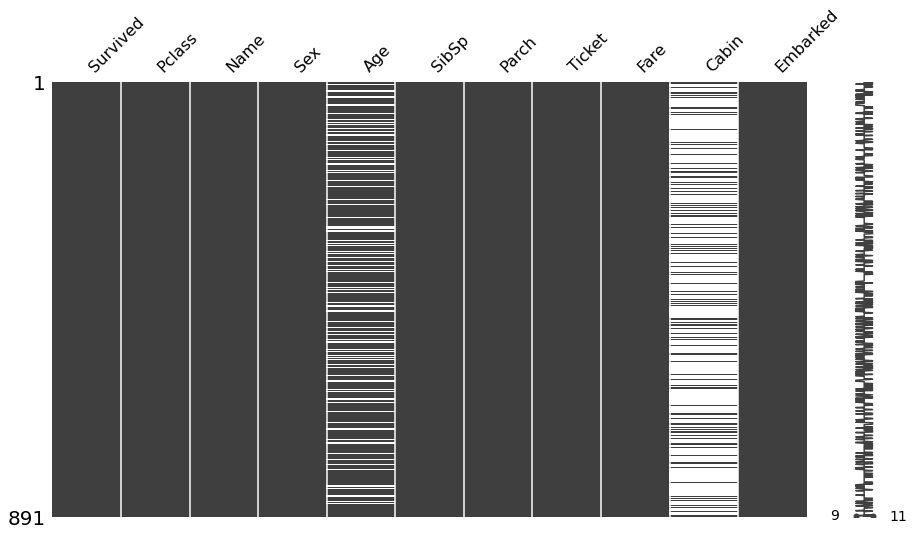

In [6]:
import missingno as msno
msno.matrix(df = train, figsize=(15, 8))

Age에서는 적당히 채울 수 있는 결측값이 발견되었고

Cabin에서는 수 많은 결측값들이 발견되었다.

Embarked에서는 그래프에서는 잘 보이지 않지만 2개의 결측값이 발견되었다.

- Embarked는 충분히 대체 가능하다고 생각
- Age는 살릴 수 있는 Column이라는 생각
- Cabin은 솔직히 불가능이라고 생각이 들었다.

<AxesSubplot:>

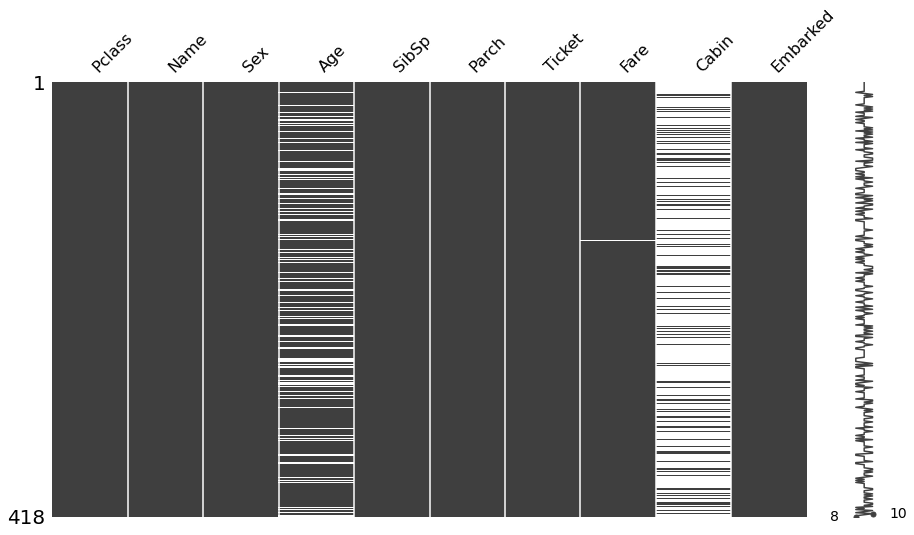

In [7]:
import missingno as msno
msno.matrix(df = test, figsize=(15, 8))

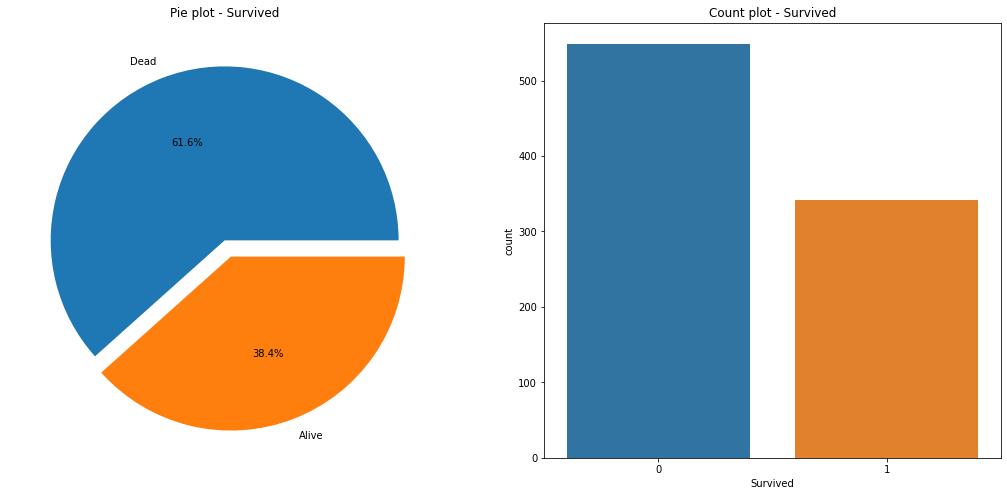

In [8]:
# 2. Target Variable Inspection
# 2. Target Variable에 대한 분석
import warnings
warnings.filterwarnings('ignore')

f, ax = plt.subplots(1, 2, figsize=(18, 8))

train['Survived'].value_counts().plot.pie(explode=[0, 0.1], labels = ['Dead', 'Alive'], autopct='%1.1f%%', ax=ax[0])
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')

sns.countplot('Survived', data=train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

비율을 보기위한 pieplot과 실제 수를 보기위한 countplot을 그려보았다.

61.6%의 사람이 죽었고 38.4%의 사람이 살아남은 것을 알 수 있으며

그 수는 500명이 넘는 사람이 죽었고 300명이 넘는 사람이 살아남은 것을 알 수 있다.

※ 나름 classification이 고르게 분포된 데이터의 형태이다.

In [9]:
# 3. Datatype Check
from collections import Counter
Counter(train.dtypes.values)

Counter({dtype('int64'): 4, dtype('O'): 5, dtype('float64'): 2})

float64 형태의 데이터가 2 -> train_float로 들어갈 예정

int64 형태의 데이터가 4 -> train_int로 들어갈 예정

Object 형태의 데이터가 5 -> train_O로 들어갈 예정

In [10]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])
train_O = train.select_dtypes(include=['O'])

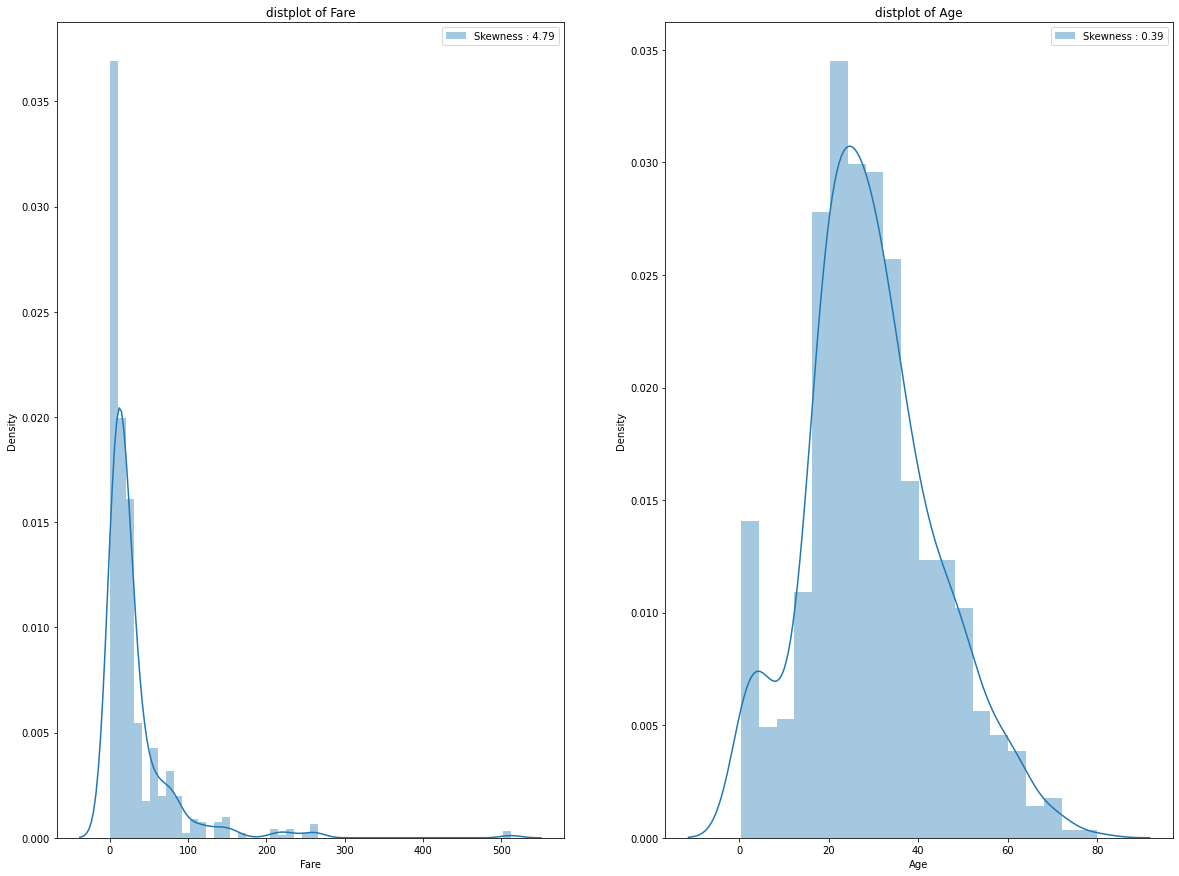

In [11]:
# 4.0 Float type Columns Inspection
# 4.0 Float type Column별 고찰

f, ax = plt.subplots(1, 2, figsize = (20, 15))
g1 = sns.distplot(train['Fare'], label='Skewness : {:.2f}'.format(train['Fare'].skew()), ax=ax[0])
g2 = sns.distplot(train['Age'], label='Skewness : {:.2f}'.format(train['Age'].skew()), ax=ax[1])

ax[0].set_title('distplot of Fare')
ax[1].set_title('distplot of Age')

g1 = g1.legend(loc = 'best')
g2 = g2.legend(loc = 'best')

Fare의 경우 왜도가 4.79로 Long-Tailed_Data의 형태를 지니고 있다.

-> 왜도가 심한 데이터를 학습 시킬 경우 예상치 못한 안타까운 상황이 일어날 수 있으니 Fare에 대해서는 log화 진행할 예정

Age의 경우 왜도가 0.39로 균형적인 분포를 이루고 있다.

-> 일단은 그냥 내비두겠다.

<AxesSubplot:>

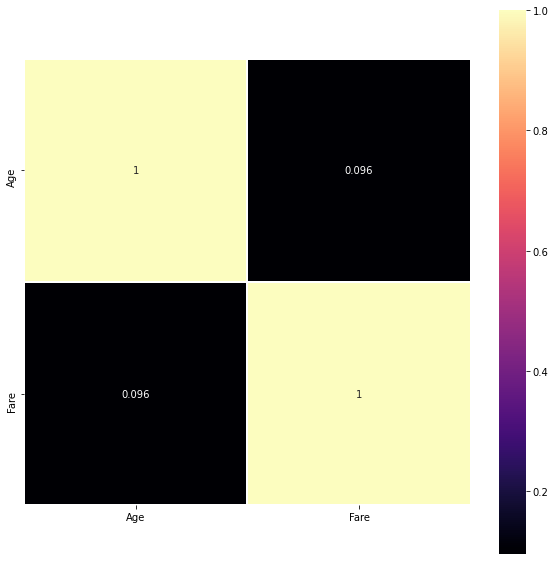

In [12]:
# ★★★★★★
# 4. Correlation plots
# 4.1 float type data 상관관계 알아보기
import plotly.graph_objs as go
import plotly.offline as py

colormap = plt.cm.magma
plt.figure(figsize=(10,10))
ax[0].set_title('Pearson correlation of continous features')
sns.heatmap(train_float.corr(), linewidth=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Age, Fare간 상관관계는 거의 없는 것으로 밝혀졌다.

물론 Age에 결측값들이 다수 있지만 유의미한 지표라고 생각한다.

In [13]:
train_O.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      891 non-null    object
 1   Sex       891 non-null    object
 2   Ticket    891 non-null    object
 3   Cabin     204 non-null    object
 4   Embarked  889 non-null    object
dtypes: object(5)
memory usage: 74.1+ KB


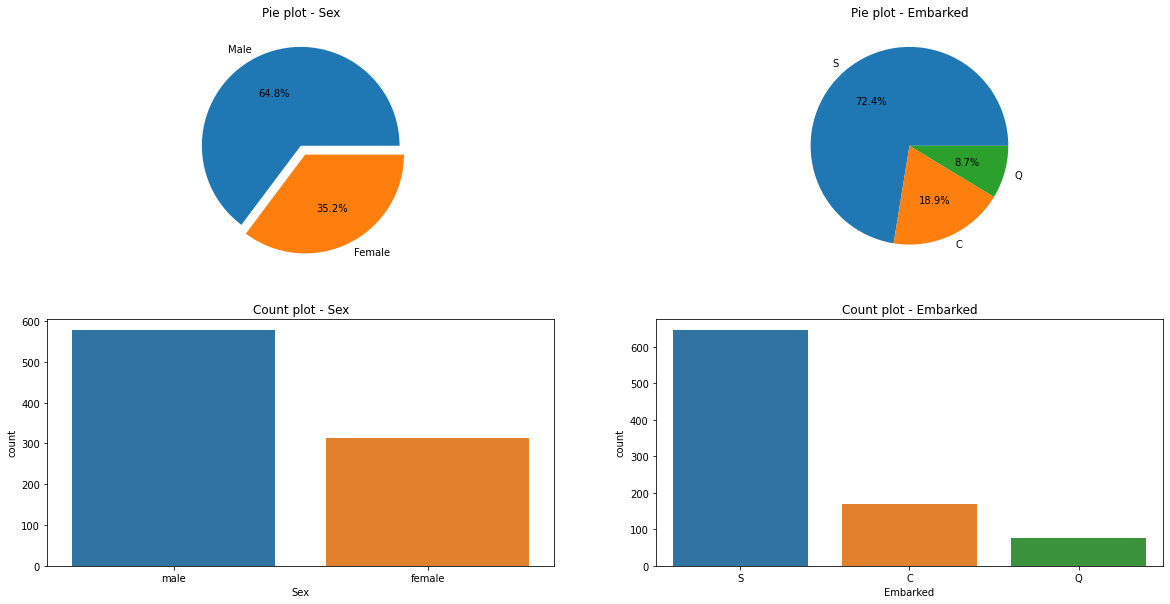

In [14]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))

train['Sex'].value_counts().plot.pie(explode=[0, 0.1], labels = ['Male', 'Female'], autopct='%1.1f%%', ax=ax[0][0])
ax[0][0].set_title('Pie plot - Sex')
ax[0][0].set_ylabel('')

train['Embarked'].value_counts().plot.pie(labels = ['S', 'C', 'Q'], autopct ='%1.1f%%', ax=ax[0][1])
ax[0][1].set_title('Pie plot - Embarked')
ax[0][1].set_ylabel('')

sns.countplot('Sex', data=train, ax=ax[1][0])
ax[1][0].set_title('Count plot - Sex')

sns.countplot('Embarked', data=train, ax=ax[1][1])
ax[1][1].set_title('Count plot - Embarked')
plt.show()

Sex의 경우 Male, Female로만 나뉘는 bin형태의 데이터

-> Male을 0 / Female을 1로 바꿔주자

Embarked의 경우 S,C,Q로만 나뉘는 Pclass와 같은 categorical 형태이다. 그래서 Embarked의 S, C, Q를 1, 2, 3으로 바꾸고 integer type으로 변환해서

정수형 타입들간의 상관관계를 살펴보고자 한다.

그 전에 Embarked의 유일한 결측값을 가장 최빈값인 S로 대체하고 나서 상관관계를 보도록 하겠다.

In [15]:
train['Embarked'].fillna('S' ,inplace=True)
train['Embarked'].replace('S', 1, inplace=True)
train['Embarked'].replace('C', 2, inplace=True)
train['Embarked'].replace('Q', 3, inplace=True)
train['Embarked'] = train['Embarked'].astype(int)

train['Sex'].replace('male', 1, inplace=True)
train['Sex'].replace('female', 2, inplace=True)

train['Family'] = train['Parch'] + train['SibSp'] + 1
train['Solo'] = (train['Family'] == 1)

train_bin = pd.DataFrame()
train_bin['Sex'] = train['Sex']
train_bin['Solo'] = train['Solo']

test['Embarked'].replace('S', 1, inplace=True)
test['Embarked'].replace('C', 2, inplace=True)
test['Embarked'].replace('Q', 3, inplace=True)
test['Embarked'] = test['Embarked'].astype(int)

test['Sex'].replace('male', 1, inplace=True)
test['Sex'].replace('female', 2, inplace=True)

test['Family'] = test['Parch'] + test['SibSp'] + 1
test['Solo'] = (test['Family'] == 1)

Parch와 SibSp는 동행자 즉 가족들을 의미하기 때문에 다 더하면 한 그룹이 완성이 된다.

Family와 Survived는 얼마나 상관관계를 지니고 있는지 궁금해서 만들어봤다.

Sex와 Embarked는 Otype에서 탈출하였으니 train_O에서 drop시켜주고 binary 종류의 데이터만 담아두는 train_bin을 만들어두자

binary_bin안에는 우선 Sex, Solo가 들어갈 예정

Text(0, 0.5, '')

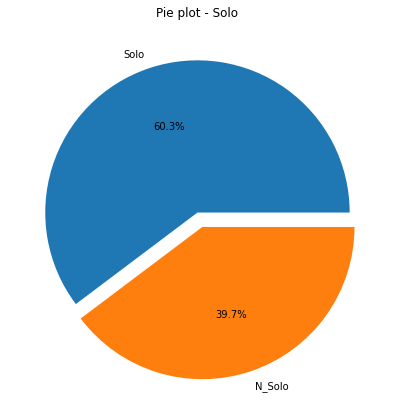

In [16]:
f, ax = plt.subplots(1, 1, figsize=(15, 7))

train['Solo'].value_counts().plot.pie(explode=[0, 0.1], labels = ['Solo', 'N_Solo'], autopct='%1.1f%%', ax=ax)
ax.set_title('Pie plot - Solo')
ax.set_ylabel('')


Text(0.5, 1.0, 'Count plot - Solo')

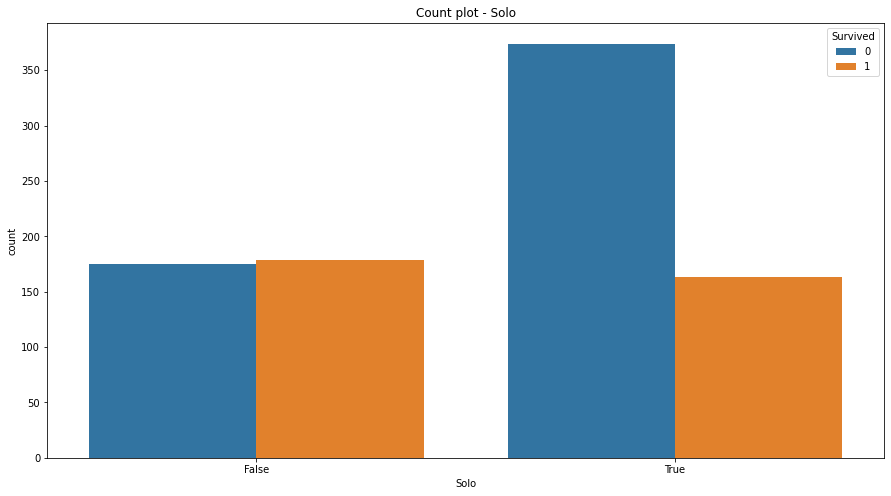

In [17]:
f, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.countplot('Solo', data=train, hue = 'Survived', ax=ax)
ax.set_title('Count plot - Solo')

혼자 있으면 얼마나 잘 살아남는지 보기 위해서 countplot으로 찍어보았다.

-> 혼자 있으면 더 생존률이 더 낮은 것이 보인다

혼자가 아닐 때는 Dead : Alive가 1:1, 둘다 180명정도에 머물렀지만, 혼자일 때는 350명이 넘게 죽었고 살아남은 사람은 180명보다 아래로 집계되었다.

In [18]:
# 4.2 integer type correlation
# 4.2 정수형 타입 상관관계
train_int['Embarked'] = train['Embarked']
train_int['Family'] = train['Family']
train_int['Sex'] = train['Sex']
data = [
    go.Heatmap(
        z=train_int.corr().values,
        x=train_int.columns.values,
        y=train_int.columns.values,
        colorscale='Greys',
        reversescale = False)
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

Parch와 SibSp에서 corr()값이 0.4정도의 강한 양의 상관 관계를 지니고 있다.

- 보통 형제가 있으면 부모가 있고
- 부모가 있으면 형제가 같이 있는 느낌이다

  == 가족이랑 같이 왔다는 것
  
Survived와 Pclass는 corr()값이 -0.3정도의 강한 음의 상관 관계를 지니고 있다.

- Pclass 값이 감소하면 (등급이 올라가면) Survived 값이 증가한다 (살아난다)

Survived와 Sex는 corr()값이 0.5정도의 강한 양의 상관 관계를 지니고 있다.

- Sex 값이 증가하면 (여자면) Survied 값이 증가한다 (살아난다) 

In [19]:
train_O.drop('Embarked', axis=1, inplace=True)
train_O.drop('Sex', axis=1, inplace=True)

In [20]:
train_O.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    891 non-null    object
 1   Ticket  891 non-null    object
 2   Cabin   204 non-null    object
dtypes: object(3)
memory usage: 60.1+ KB


Sex, Embarked를 빼준 train_O에는 Ticket, Name, Cabin Columns만 남았다.

이 중 대략 70프로가 결측값으로 이루어진 Cabin Column은 지우고 예측을 하는 것이 맞다고 판단 -> drop시켜주자

In [21]:
train.drop('Cabin', axis=1, inplace=True)
train_O.drop('Cabin', axis=1, inplace=True)

In [22]:
# 4.3 O type Inspection and PreProcessing
# 4.3 O 타입 고찰과 전처리 과정
train['Name'].value_counts()

Thorne, Mrs. Gertrude Maybelle    1
Peters, Miss. Katie               1
O'Leary, Miss. Hanora "Norah"     1
Lindqvist, Mr. Eino William       1
Simmons, Mr. John                 1
                                 ..
Flynn, Mr. John                   1
Skoog, Miss. Margit Elizabeth     1
Risien, Mr. Samuel Beard          1
Goldschmidt, Mr. George B         1
Stankovic, Mr. Ivan               1
Name: Name, Length: 891, dtype: int64

Name의 value_counts()값을 확인 해보니 호칭이 눈에 띄는 것을 볼 수 있었다.

**, 다음부터 .이 나오기 전까지의 문자열**을 Parsing하면 호칭을 따로 얻을 수 있을 거라 판단



In [23]:
train['Title'] = train['Name'].str.extract('([,A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract('([,A-Za-z]+)\.', expand=False)

위에 생각한 규칙대로 정규표현식을 사용해서 parsing을 진행하였다.

Parsing된 string 값들은 'Title'이라는 새로운 column을 만들어 저장하였다.

In [24]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Countess      1
Don           1
Ms            1
Lady          1
Jonkheer      1
Mme           1
Sir           1
Capt          1
Name: Title, dtype: int64

호칭 정리 

- Master   : Mr와 같은 뜻이지만 존경을 담아서
- Dr       : 박사님, 의사님
- Rev      : 목사님
- Mlle     : 마드모아젤 (미혼 여성)
- Major    : 군대 장교 계급
- Col      : 대령
- Sir      : 남자 (존칭)
- Lady     : 미혼여성
- Ms       : 미혼 or 기혼 여성(모름)
- Jonkheer : 귀족 직함(낮음)
- Countess : 백작
- Capt     : 선장, 지휘관
- Mme      : 마담 (여성 존칭)
- Don      : 남성 두목(Mr와 같은 의미)

Mlle, Lady -> Miss (완벽한 미혼여성)

Ms, Mme - > Mrs (감추려고 한다는 뜻 == 결혼함)

Major, Col, Sir, Jonkheer, Countess, Capt, Don -> Mr (일반적인 남성)

바꿔주면 될거라고 생각함

In [25]:
train['Title'].replace(['Mlle', 'Lady'], ['Miss', 'Miss'], inplace=True)
train['Title'].replace(['Ms', 'Mme'], ['Mrs', 'Mrs'], inplace=True)
train['Title'].replace(['Major', 'Col', 'Sir', 'Jonkheer', 'Countess', 'Capt', 'Don'], ['Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr'], inplace=True)

test['Title'].replace(['Mlle', 'Lady'], ['Miss', 'Miss'], inplace=True)
test['Title'].replace(['Ms', 'Mme'], ['Mrs', 'Mrs'], inplace=True)
test['Title'].replace(['Major', 'Col', 'Sir', 'Jonkheer', 'Countess', 'Capt', 'Don'], ['Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr', 'Mr'], inplace=True)

In [26]:
train['Title'].value_counts()

Mr        526
Miss      185
Mrs       127
Master     40
Dr          7
Rev         6
Name: Title, dtype: int64

Text(0.5, 1.0, 'Title CountPlot according to Survived')

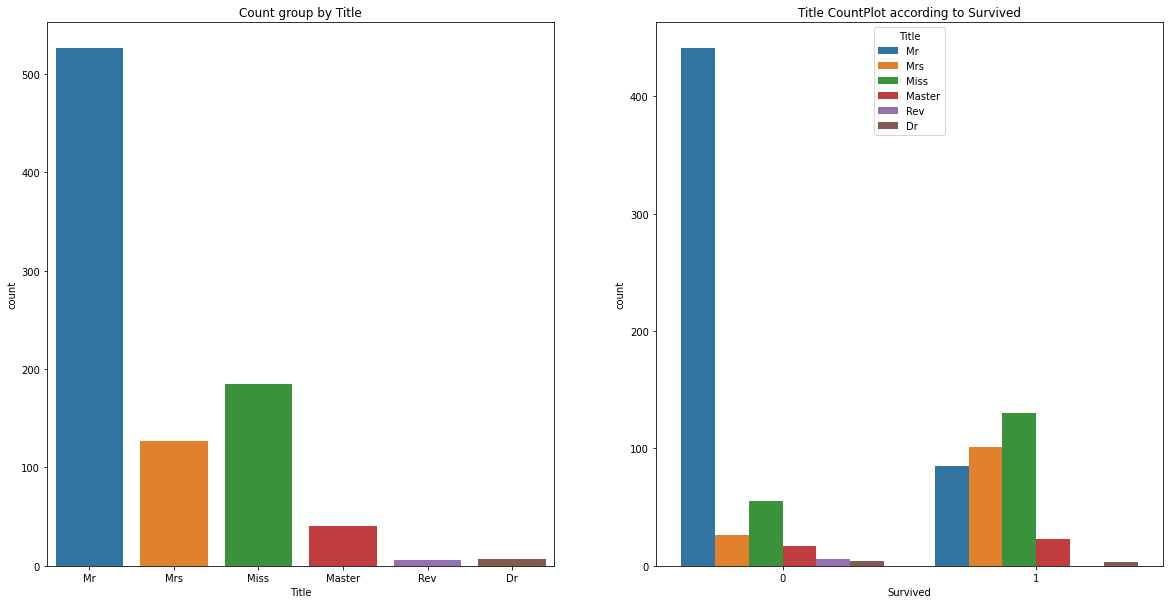

In [27]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.countplot(x = 'Title', data = train, ax=ax[0])
ax[0].set_title('Count group by Title')
sns.countplot(x = 'Survived', hue='Title', data = train, ax = ax[1])
ax[1].set_title('Title CountPlot according to Survived')

Mr의 호칭을 지닌 사람들이 엄청나게 많이 죽었다.

그에 반면 Mrs, Miss의 호칭을 지닌 사람들은 많이 살았다.

Rev(목사님)들은 다 죽으셨고... ㅠ

하여튼 개수가 거의 없던 호칭들을 통합하여 plot을 그려보았더니 나쁘지 않은 그래프가 나타났다.

물론 Rev, Dr의 수가 적은게 불안하지만 그래도 Rev들이 다 죽은 결과 또한 반영할 수 있을 거라고 생각하였다.

이 또한 categorical 범주이니 추후 1 2 3 4 5 6 으로 cat 시키도록 하겠다.

In [28]:
# 4.3.1 'Ticket' column Insepction, PreProcessing
# 4.3.1 '티켓'열 고찰, 전처리
train['Ticket'].value_counts()

CA. 2343    7
347082      7
1601        7
3101295     6
347088      6
           ..
382649      1
234604      1
315089      1
347071      1
237798      1
Name: Ticket, Length: 681, dtype: int64

티켓들의 Value가 전부 다 unique한 것이 아닌 같은 Value를 가지는 Ticket들이 존재 == 같은 Parch or 같은 SibSp or 같은 Embarked .. 

무언가 접점이 있을 것이라고 생각하지만 나의 pandas 지식이 일천해서 구현을 하지 못하는 것이 너무나 안타깝다...

같은 ticket 값을 가지는 행들 끼리 묶어서 모든 Column에 대해서 비교해 보고 싶다...

하지만 아직 못했으니 일단 버리기로 생각했다.

In [29]:
train.drop('Ticket', axis=1, inplace=True)
test.drop('Ticket', axis=1, inplace=True)

In [30]:
# Conclusion
# To be Continued...
train.to_csv('train1.csv')
test.to_csv('test1.csv')

우선 Column들에 대한 분석은 끝냈다.

다음으로 진행할 것은 지금 했던 과정들을 Test.csv에 대해서 똑같이 적용해야 하고

무려 200개의 결측값을 가지고 있는 'Age' Column에 대해서 결측값 예측을 진행해야한다.

아마 Age Column에 대해 예측할 때는 Machine Learning을 사용하여 예측을 진행해볼까 한다. ex) Linear Regression, SVC, ...등등

Age Column에 대해서 결측값 예측이 끝난 후에는 우리의 목표 Target Column에 대해서 예측을 진행 할 예정입니다.

앞으로 열심히 해보겠습니다!!